In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras 
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import os
from keras.layers import BatchNormalization
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import natsort as nt

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from keras.layers import Dense, Dropout, Flatten

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [6]:
# set to run in float16
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5


In [8]:
# load data stored at windows partiton (remember to load the drive)
img_data = np.array([cv2.imread(file,0) for file in nt.natsorted(glob.glob("/media/rifqiaufan/Local Disk/Dataset/img_set/img_set_10/*.jpg"))])
label_data = pd.read_csv('/media/rifqiaufan/Local Disk/Dataset/img_set/label_10_binary.csv', names = ['grade'],header=None)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.33, random_state=133)

In [10]:
regularizer = tf.keras.regularizers.l1_l2(l1 = 0,l2=0.1)

In [11]:
# setup network

model = Sequential()

model.add(Conv2D(16,(2,2),
         activation = 'relu', input_shape = (64,64,1),padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(2,2),
         activation = 'relu', input_shape = (64,64,1),padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(2,2),
         activation = 'relu',padding = 'same'))
model.add(Conv2D(32,(2,2),
         activation = 'relu',padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(Dense(8, activation='relu',kernel_regularizer=regularizer))
model.add(Dropout(.5))
model.add(Dense(2, activation='softmax'))

model.summary()

# ,kernel_regularizer=regularizer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0

In [12]:
# serialize model/network to JSON and save it into the disk
model_json = model.to_json()
with open("model10_binary.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to disk")

Saved model to disk


In [13]:
## Load trained model for further training

# load saved model
# json_file = open('model10_binary.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# model.summary()

In [13]:
# reshape the data for training and validation

from tensorflow.keras.utils import to_categorical


print (X_train.shape)
print (X_test.shape)
train_images = X_train.reshape((X_train.shape[0], 64, 64, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test.reshape((X_test.shape[0], 64, 64, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

(5788, 64, 64)
(2852, 64, 64)


Epoch 1/200
243/243 [==============================] - ETA: 0s - loss: 1.6311 - accuracy: 0.7168
Epoch 00001: val_accuracy improved from -inf to 0.72318, saving model to best_model10_binary.h5
243/243 [==============================] - 2s 9ms/step - loss: 1.6311 - accuracy: 0.7168 - val_loss: 1.1928 - val_accuracy: 0.7232
Epoch 2/200
236/243 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.7211
Epoch 00002: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.9852 - accuracy: 0.7209 - val_loss: 0.8145 - val_accuracy: 0.7232
Epoch 3/200
239/243 [============================>.] - ETA: 0s - loss: 0.7397 - accuracy: 0.7207
Epoch 00003: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.7385 - accuracy: 0.7209 - val_loss: 0.6709 - val_accuracy: 0.7232
Epoch 4/200
243/243 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.7209
Epoch 00004: 

Epoch 30/200
243/243 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.7209
Epoch 00030: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4595 - accuracy: 0.7209 - val_loss: 0.3939 - val_accuracy: 0.7232
Epoch 31/200
239/243 [============================>.] - ETA: 0s - loss: 0.4645 - accuracy: 0.7202
Epoch 00031: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4650 - accuracy: 0.7209 - val_loss: 0.3774 - val_accuracy: 0.7232
Epoch 32/200
239/243 [============================>.] - ETA: 0s - loss: 0.4577 - accuracy: 0.7223
Epoch 00032: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4582 - accuracy: 0.7209 - val_loss: 0.3725 - val_accuracy: 0.7232
Epoch 33/200
237/243 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.7202
Epoch 00033: val_accuracy did not improve from 0.7

Epoch 59/200
236/243 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.7190
Epoch 00059: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4509 - accuracy: 0.7209 - val_loss: 0.3618 - val_accuracy: 0.7232
Epoch 60/200
235/243 [============================>.] - ETA: 0s - loss: 0.4510 - accuracy: 0.7197
Epoch 00060: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4488 - accuracy: 0.7209 - val_loss: 0.3737 - val_accuracy: 0.7232
Epoch 61/200
242/243 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.7208
Epoch 00061: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4458 - accuracy: 0.7209 - val_loss: 0.3586 - val_accuracy: 0.7232
Epoch 62/200
241/243 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.7212
Epoch 00062: val_accuracy did not improve from 0.7

Epoch 88/200
237/243 [============================>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.7213
Epoch 00088: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4444 - accuracy: 0.7209 - val_loss: 0.3661 - val_accuracy: 0.7232
Epoch 89/200
242/243 [============================>.] - ETA: 0s - loss: 0.4451 - accuracy: 0.7206
Epoch 00089: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4449 - accuracy: 0.7209 - val_loss: 0.3610 - val_accuracy: 0.7232
Epoch 90/200
237/243 [============================>.] - ETA: 0s - loss: 0.4452 - accuracy: 0.7226
Epoch 00090: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4467 - accuracy: 0.7209 - val_loss: 0.3603 - val_accuracy: 0.7232
Epoch 91/200
235/243 [============================>.] - ETA: 0s - loss: 0.4406 - accuracy: 0.7194
Epoch 00091: val_accuracy did not improve from 0.7

Epoch 117/200
236/243 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.7206
Epoch 00117: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4390 - accuracy: 0.7209 - val_loss: 0.3480 - val_accuracy: 0.7232
Epoch 118/200
241/243 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.7210
Epoch 00118: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4400 - accuracy: 0.7209 - val_loss: 0.3506 - val_accuracy: 0.7232
Epoch 119/200
238/243 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.7219
Epoch 00119: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4361 - accuracy: 0.7209 - val_loss: 0.3576 - val_accuracy: 0.7232
Epoch 120/200
236/243 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.7225
Epoch 00120: val_accuracy did not improve from

Epoch 146/200
243/243 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.7209
Epoch 00146: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4327 - accuracy: 0.7209 - val_loss: 0.3465 - val_accuracy: 0.7232
Epoch 147/200
242/243 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.7213
Epoch 00147: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4369 - accuracy: 0.7209 - val_loss: 0.3845 - val_accuracy: 0.7232
Epoch 148/200
237/243 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.7197
Epoch 00148: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4321 - accuracy: 0.7209 - val_loss: 0.3419 - val_accuracy: 0.7232
Epoch 149/200
239/243 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.7207
Epoch 00149: val_accuracy did not improve from

Epoch 175/200
237/243 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.7213
Epoch 00175: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4268 - accuracy: 0.7209 - val_loss: 0.3461 - val_accuracy: 0.7232
Epoch 176/200
237/243 [============================>.] - ETA: 0s - loss: 0.4247 - accuracy: 0.7210
Epoch 00176: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4242 - accuracy: 0.7209 - val_loss: 0.3378 - val_accuracy: 0.7232
Epoch 177/200
235/243 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.7213
Epoch 00177: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.4309 - accuracy: 0.7209 - val_loss: 0.3367 - val_accuracy: 0.7232
Epoch 178/200
237/243 [============================>.] - ETA: 0s - loss: 0.4289 - accuracy: 0.7202
Epoch 00178: val_accuracy did not improve from

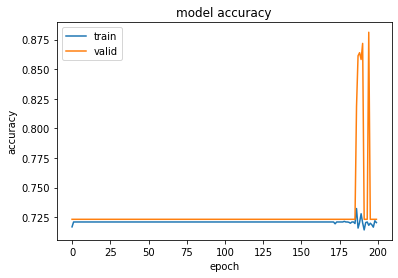

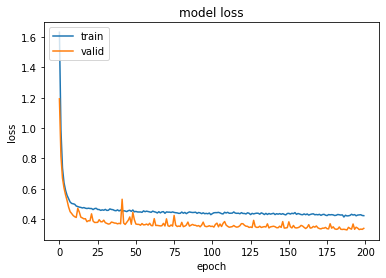

90/90 [==============================] - 0s 3ms/step - loss: 0.3384 - accuracy: 0.7255
Test accuracy: 0.7254558205604553


In [14]:
# hyperparameter setup

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)

# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=200)
mc = ModelCheckpoint('best_model10_binary.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    validation_split=0.33,
                    batch_size=16,
                    epochs=200,
                    verbose=1,
                    callbacks = [es,mc])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

In [71]:
# # load existing json model for statistics
# json_file = open('model10_binary.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)

# model.load_weights("best_model10_binary.h5")

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [16]:
# predict probabilities for test set
yhat_probs = model.predict(test_images, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(test_images, verbose=0), axis=-1)#model.predict_classes(test_images, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]
 
test_val = np.array(y_test['grade'])
test_labels_mod = test_labels[:,0]


In [17]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_val, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_val, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_val, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_val, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(test_val, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_labels_mod, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_val, yhat_classes)
print(matrix)

Accuracy: 0.725456
Precision: 0.725456
Recall: 1.000000
F1 score: 0.840886
Cohens kappa: 0.000000
ROC AUC: 0.944210
[[   0  783]
 [   0 2069]]


In [18]:
tn, fp, fn, tp = confusion_matrix(test_val, yhat_classes).ravel()
(tn, fp, fn, tp)

(0, 783, 0, 2069)

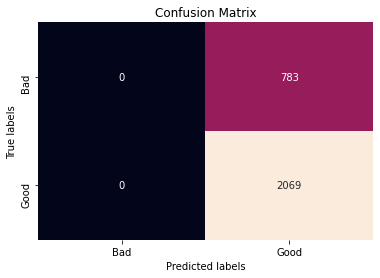

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax,fmt='d', cbar = False); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Bad', 'Good']); ax.yaxis.set_ticklabels(['Bad', 'Good']);

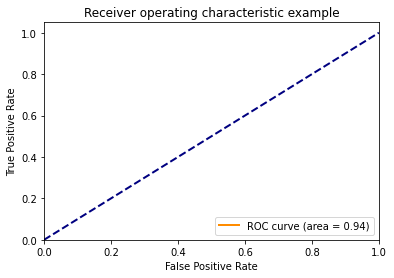

In [21]:
plt.figure()
lw = 2
plt.plot(fp, tp, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
predictions = model.predict(test_images, verbose=0)
fix_score = y_test['grade']
test_labels_mod = fix_score.values.tolist()
class_names = ['bad','good']

In [23]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img,cmap='gray')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color,
                                fontsize=80)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([0,1],['Bad','Good'])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

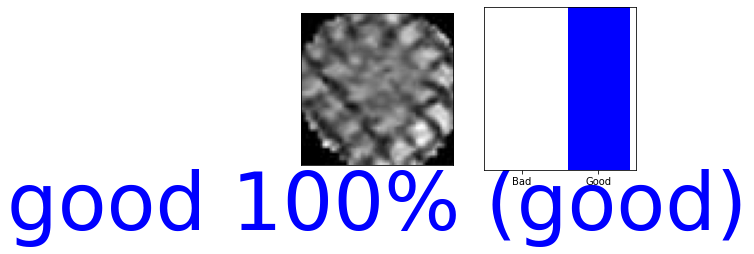

In [24]:
# test outpu classification
i = 6
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels_mod, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels_mod)
plt.show()

In [25]:
import matplotlib 
matplotlib.rc('xtick', labelsize=80) 
matplotlib.rc('ytick', labelsize=80) 

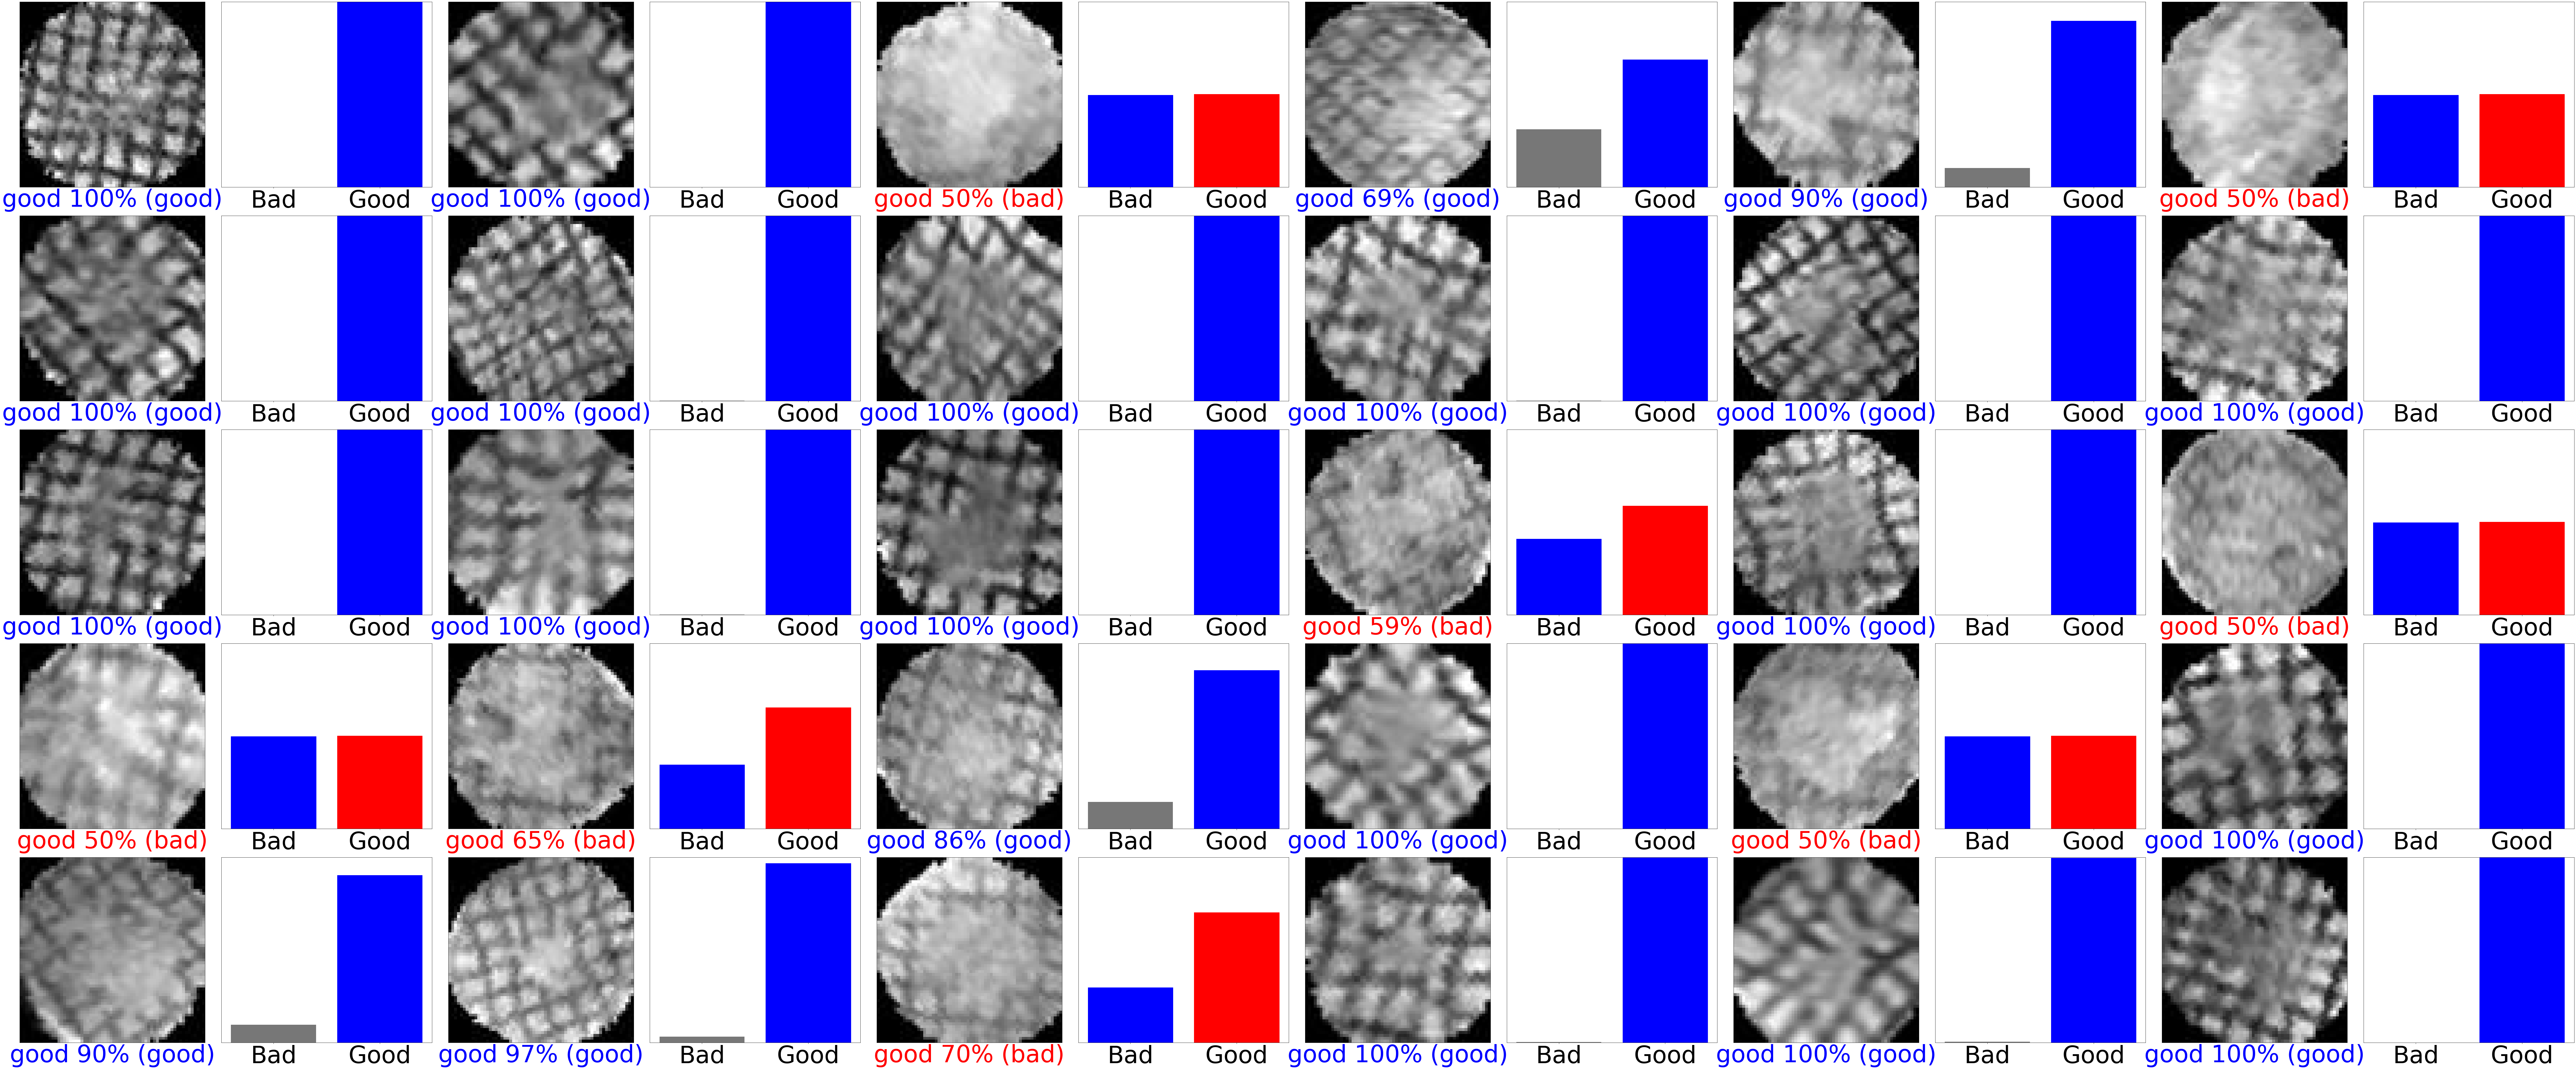

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.


num_rows = 5
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*10*num_cols, 10*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_mod, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_mod)
plt.tight_layout()
plt.show()